# Data Exploration for Dereks Paints
This notebook explores the data provided to be used in the SMA project

In [114]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats

In [132]:
raw_data = pd.read_csv('/Users/isaiah/Downloads/data_sma.csv')
raw_data.head()

analysis_data = raw_data[[
    'Key', 
    'Batch No.',
    'Product Code', 
    'Description', 
    'Process/Step Name', 
    'Machine', 
    'Start Datetime', 
    'End Datetime', 
    'Process Duration (min)'
]].rename(columns={
    'Key': 'key',
    'Batch No.': 'batch_no',
    'Product Code': 'product_code',
    'Description': 'description',
    'Process/Step Name': 'step_name',
    'Machine': 'machine',
    'Start Datetime': 'start_time',
    'End Datetime': 'end_time',
    'Process Duration (min)': 'duration_min'
})
analysis_data.head()


,key,batch_no,product_code,description,step_name,machine,start_time,end_time,duration_min
0,f3c3k31NgpnvqIZaDuM99S,oLMc9CXMmw4YmaRfiR5TCf,RM2-ACX-40,DAVIES ACREEX MARKING YELLOW,PMWS Printing,NaN,4/19/2024 14:42:00,4/19/2024 14:43:00,1.0
1,oiIPn9M3acQY3LBNKFpnfO,oLMc9CXMmw4YmaRfiR5TCf,RM2-ACX-40,DAVIES ACREEX MARKING YELLOW,FG Transfer,NaN,5/7/2024 11:34:00,5/7/2024 14:33:00,179.0
2,txPWzoriKMuP4Le4ZUQOUo,hZCShlxunF00aENM9WmouD,RM2-ACX-21,DAVIES ACREEX CRYSTAL BLUE,Premix,HSM-1,5/9/2024 11:20:00,5/9/2024 11:35:00,15.0
3,c2A9zmR2vTHvfbnDogjUSv,hZCShlxunF00aENM9WmouD,RM2-ACX-21,DAVIES ACREEX CRYSTAL BLUE,Grind (Part A),BKM-11,5/10/2024 7:30:00,5/10/2024 12:30:00,300.0
4,IYjn62HQLzvLszapEjZqzF,hZCShlxunF00aENM9WmouD,RM2-ACX-21,DAVIES ACREEX CRYSTAL BLUE,Grits Check,BKM-11,5/10/2024 12:30:00,5/10/2024 14:30:00,120.0


In [16]:
analysis_data['product_code'].value_counts()

product_code
RM2-ACX-40    581
RM2-ACX-60    431
RM2-ACX-21    401
Name: count, dtype: int64

In [133]:
analysis_data['step_name'].value_counts()

step_name
Load                    355
Grits Check             300
Grind (Part A)          120
Premix                   91
Grind (Part B)           90
SAP Posting - Std        85
Transfer of Millbase     81
FG Transfer              80
Letdown                  80
PMWS Printing            55
Grind                    37
Adjust                   17
Packing                  14
Labelling                 6
Tint                      2
Name: count, dtype: int64

# Time Distribution
Analysing time

In [134]:
analysis_data['duration_min'].describe()

count     1396.000000
mean       124.256447
std       1421.573816
min          0.000000
25%         15.000000
50%         30.000000
75%         75.000000
max      38900.000000
Name: duration_min, dtype: float64

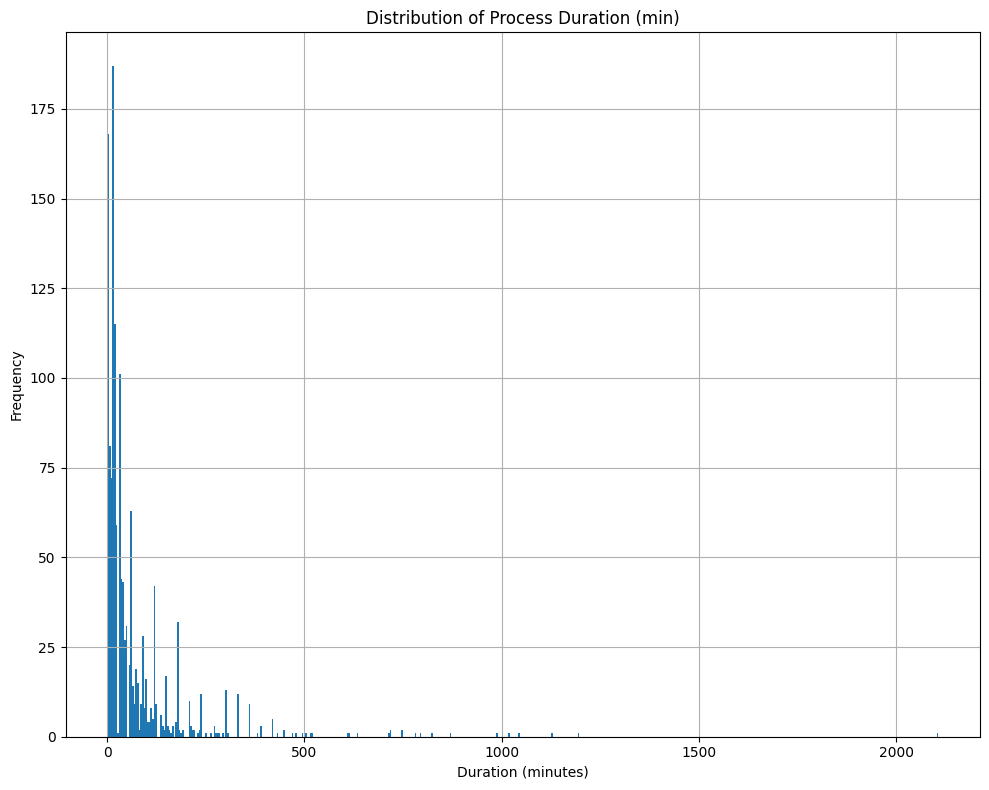

In [135]:
# Filter out unusually long durations
filtered_data = analysis_data[analysis_data['duration_min'] <= 3000]

# Plot histogram
plt.figure(figsize=(10, 8))
filtered_data['duration_min'].hist(bins=500)

plt.title('Distribution of Process Duration (min)')
plt.xlabel('Duration (minutes)')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()


# Frequency of Machine Use

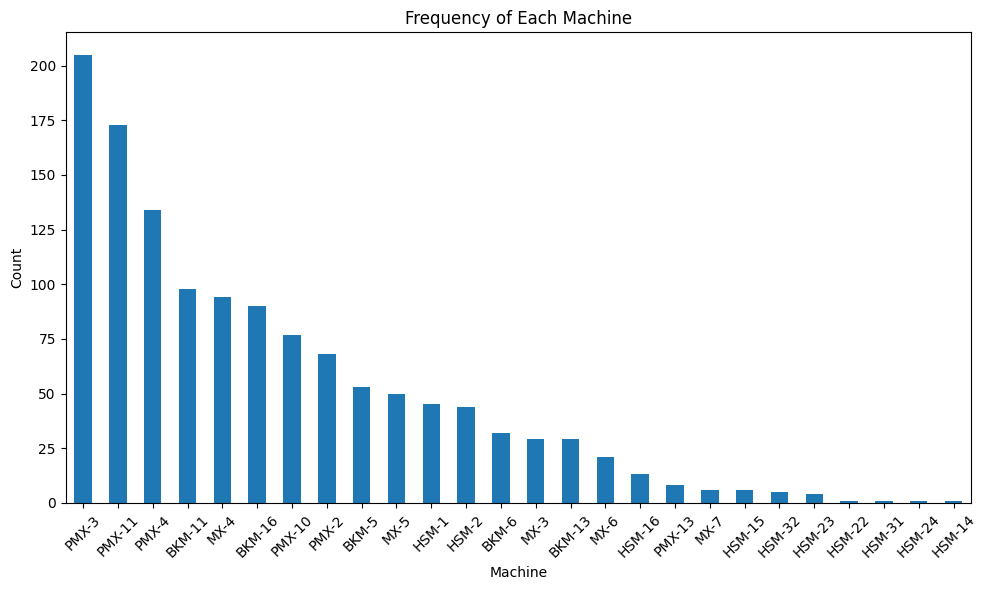

In [66]:
machine_counts = filtered_data['machine'].value_counts()

plt.figure(figsize=(10, 6))
machine_counts.plot(kind='bar')
plt.title('Frequency of Each Machine')
plt.xlabel('Machine')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

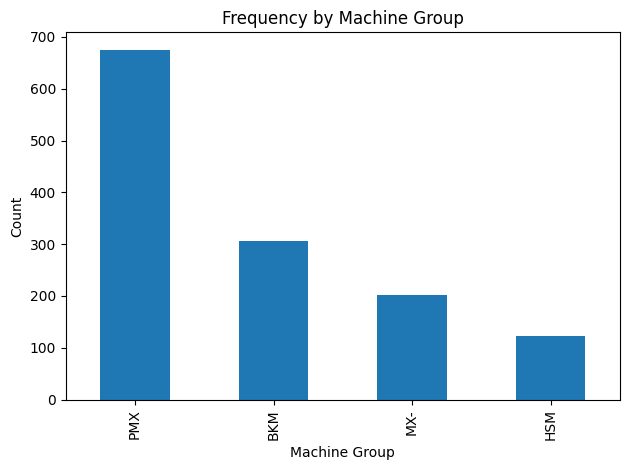

In [137]:
analysis_data['machine_group'] = analysis_data['machine'].str[:3]
analysis_data['machine_group'].value_counts().plot(kind='bar')
plt.title('Frequency by Machine Group')
plt.xlabel('Machine Group')
plt.ylabel('Count')
plt.tight_layout()
plt.show()


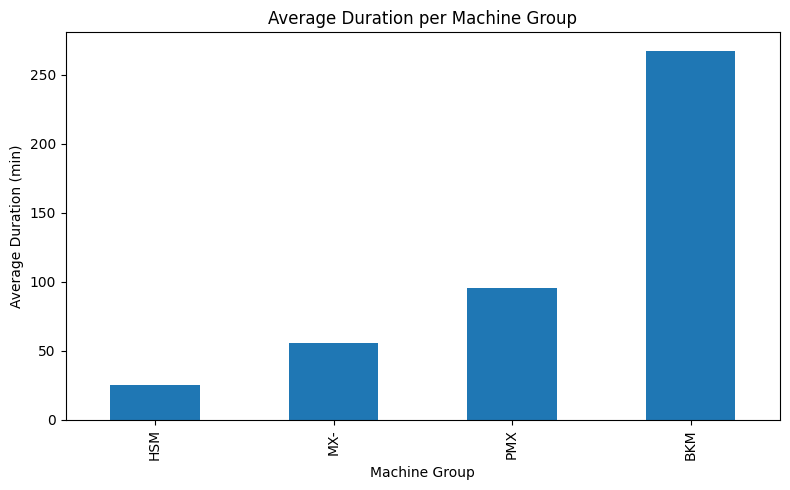

In [136]:
# Create machine group column
analysis_data['machine_group'] = analysis_data['machine'].str[:3]

# Group and calculate mean duration
avg_duration = analysis_data.groupby('machine_group')['duration_min'].mean().sort_values()

# Plot
plt.figure(figsize=(8, 5))
avg_duration.plot(kind='bar')
plt.title('Average Duration per Machine Group')
plt.xlabel('Machine Group')
plt.ylabel('Average Duration (min)')
plt.tight_layout()
plt.show()


# Retaining Needed Data


In [139]:
# First, drop rows where 'machine' doesn't contain a dash
analysis_data = analysis_data[analysis_data['machine'].str.contains('-', na=False)]

# Split into prefix and suffix
analysis_data[['machine_prefix', 'machine_num']] = analysis_data['machine'].str.split('-', expand=True)

# Safely convert machine_num to integer (only where possible)
analysis_data = analysis_data.dropna(subset=['machine_num'])  # drop any remaining NaNs
analysis_data['machine_num'] = analysis_data['machine_num'].astype(int)

# Define allowed combinations
allowed_machines = {
    'HSM': [1],
    'BKM': [5, 6, 11, 16],
    'PMX': [2, 4],
    'MX':  [3, 4, 5, 6, 7]
}

# Filter using the conditions
filtered_data = analysis_data[
    analysis_data.apply(lambda row: row['machine_num'] in allowed_machines.get(row['machine_prefix'], []), axis=1)
]


In [140]:
filtered_data['machine'].value_counts()

machine
PMX-4     135
BKM-11     98
MX-4       95
BKM-16     94
PMX-2      68
BKM-5      54
MX-5       50
HSM-1      45
BKM-6      32
MX-3       29
MX-6       22
MX-7        6
Name: count, dtype: int64

In [141]:
filtered_data = filtered_data[filtered_data['duration_min'] < 3000]
filtered_data.shape


(720, 12)

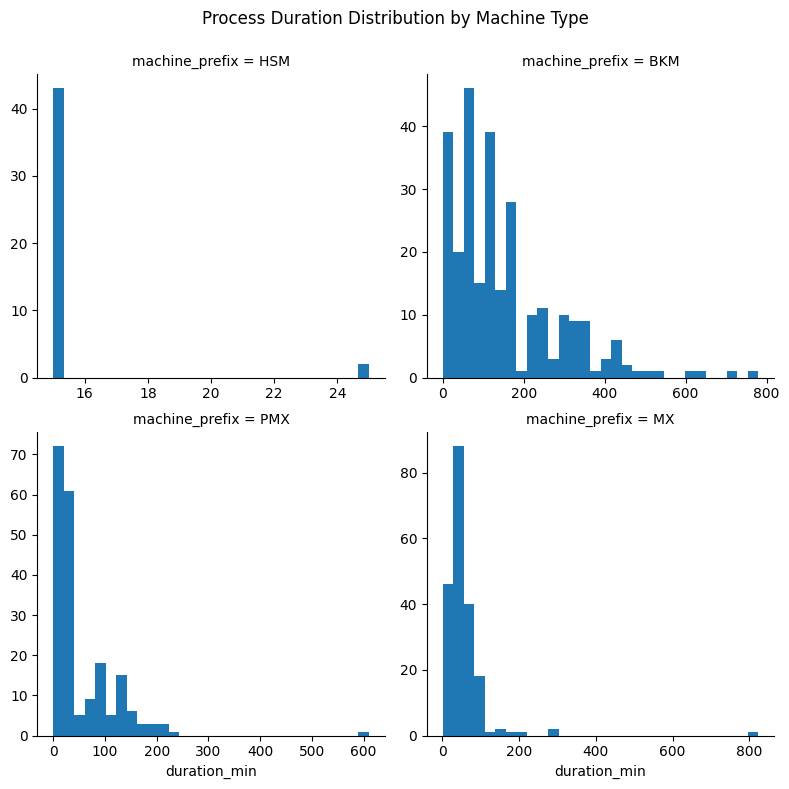

In [142]:
g = sns.FacetGrid(filtered_data, col="machine_prefix", col_wrap=2, height=4, sharex=False, sharey=False)
g.map(plt.hist, "duration_min", bins=30)
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle("Process Duration Distribution by Machine Type")
plt.show()


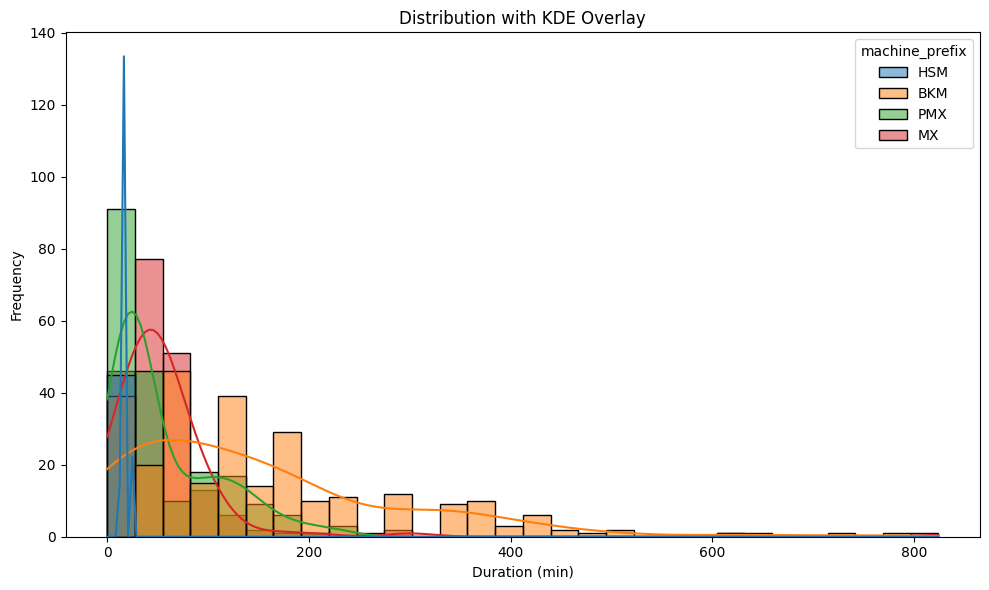

In [143]:
plt.figure(figsize=(10, 6))
sns.histplot(data=filtered_data, x="duration_min", hue="machine_prefix", kde=True, bins=30)
plt.title("Distribution with KDE Overlay")
plt.xlabel("Duration (min)")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()


In [144]:
# Create a new column with log-transformed duration
filtered_data['log_duration'] = np.log1p(filtered_data['duration_min'])


In [145]:
filtered_data['step_name'].value_counts()

step_name
Load                    164
Grits Check             107
Grind (Part A)          104
Grind (Part B)           69
Transfer of Millbase     57
Letdown                  52
Premix                   45
SAP Posting - Std        38
Grind                    26
PMWS Printing            22
FG Transfer              22
Adjust                    6
Packing                   6
Tint                      2
Name: count, dtype: int64

# Data Transformation
Since the values are right-skewed (expected from Machine Processes) we apply log transformation learnt from SML to better visualise the data and observe any potential distribution

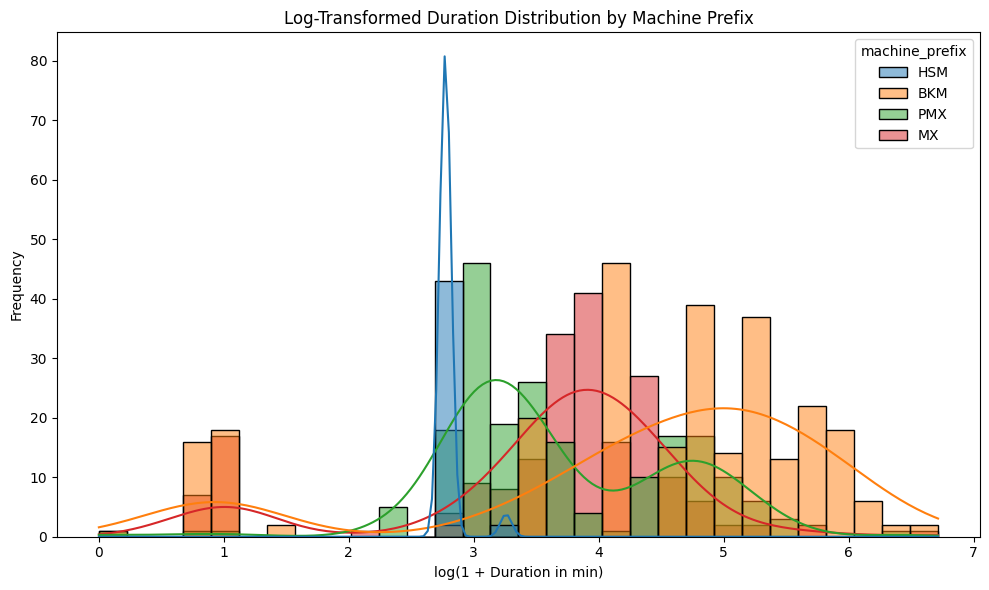

In [146]:
plt.figure(figsize=(10, 6))
sns.histplot(data=filtered_data, x="log_duration", hue="machine_prefix", kde=True, bins=30)
plt.title("Log-Transformed Duration Distribution by Machine Prefix")
plt.xlabel("log(1 + Duration in min)")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

In [147]:
from scipy.stats import normaltest

for prefix in filtered_data['machine_prefix'].unique():
    subset = filtered_data[filtered_data['machine_prefix'] == prefix]['log_duration']
    stat, p = normaltest(subset)
    print(f"{prefix}: stat={stat:.2f}, p-value={p:.4f}")


HSM: stat=74.19, p-value=0.0000
BKM: stat=52.52, p-value=0.0000
PMX: stat=5.03, p-value=0.0810
MX: stat=43.99, p-value=0.0000


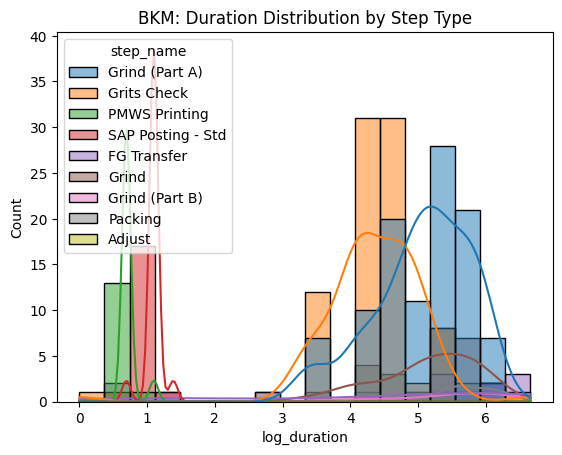

In [148]:
sns.histplot(data=filtered_data[filtered_data['machine_prefix'] == 'BKM'],
             x='log_duration', hue='step_name', kde=True)
plt.title('BKM: Duration Distribution by Step Type')
plt.show()


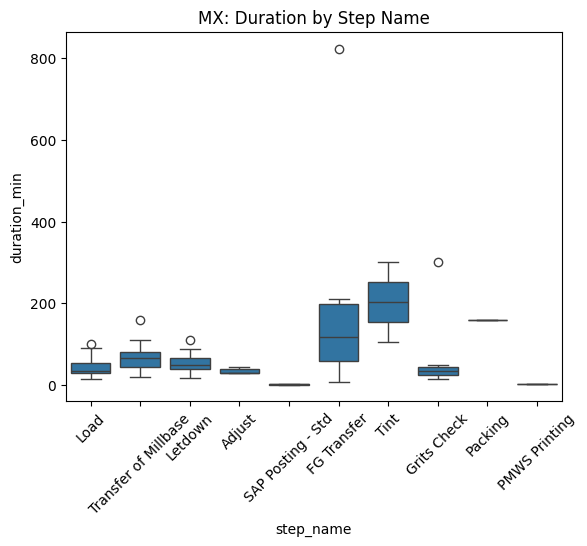

In [149]:
sns.boxplot(data=filtered_data[filtered_data['machine_prefix'] == 'MX'],
            x='step_name', y='duration_min')
plt.xticks(rotation=45)
plt.title('MX: Duration by Step Name')
plt.show()


# Visualising Machine Level Durations

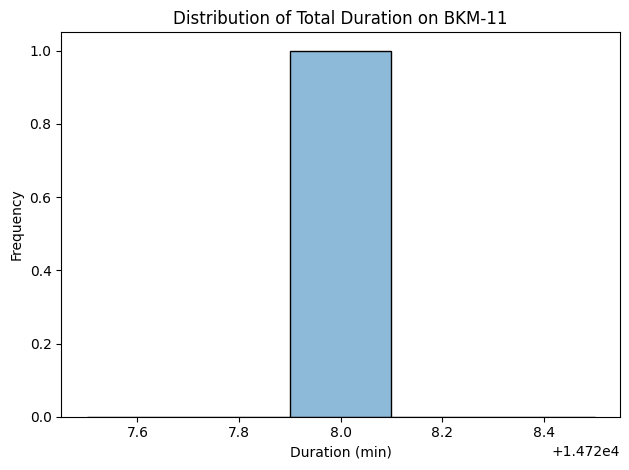

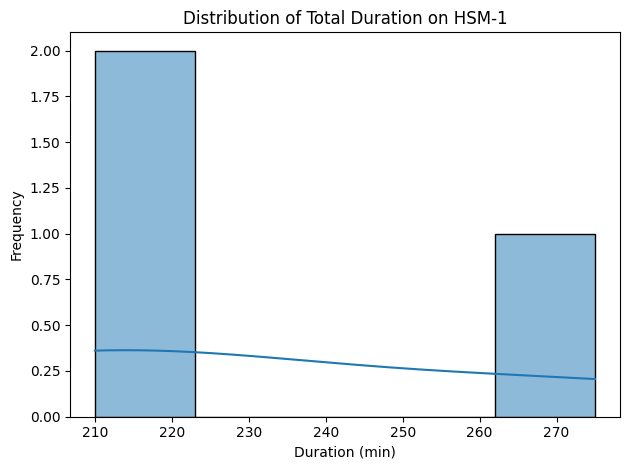

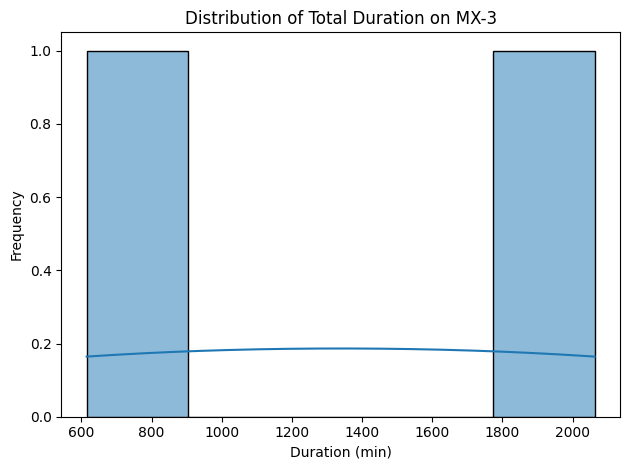

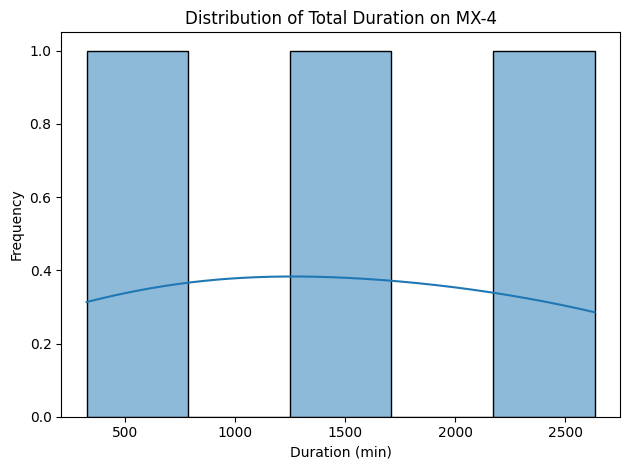

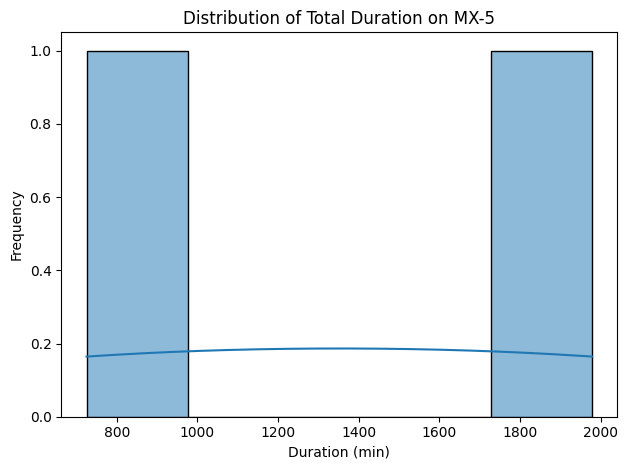

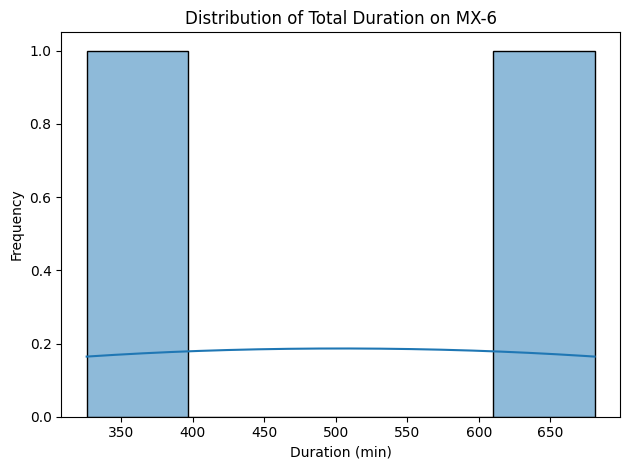

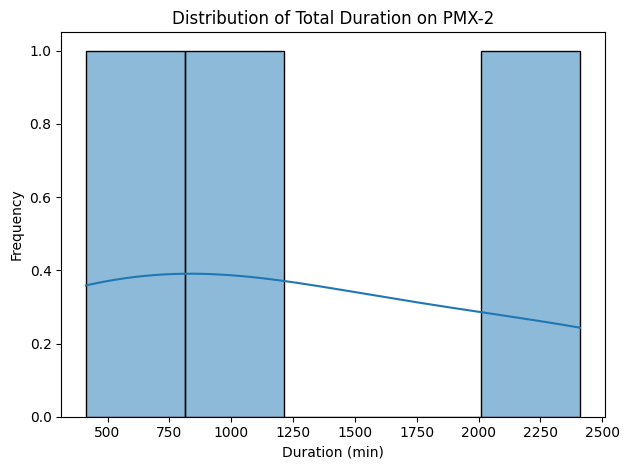

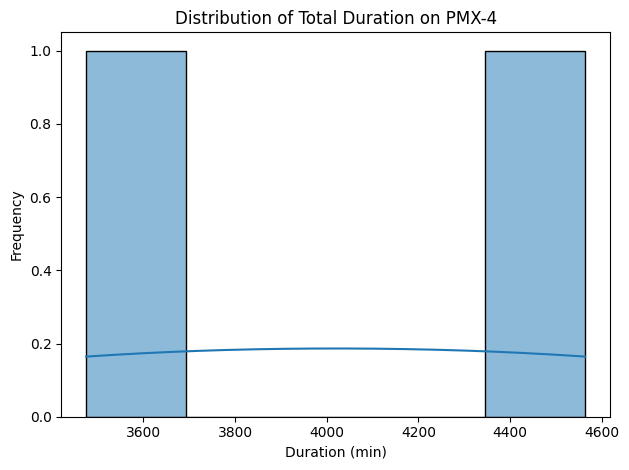

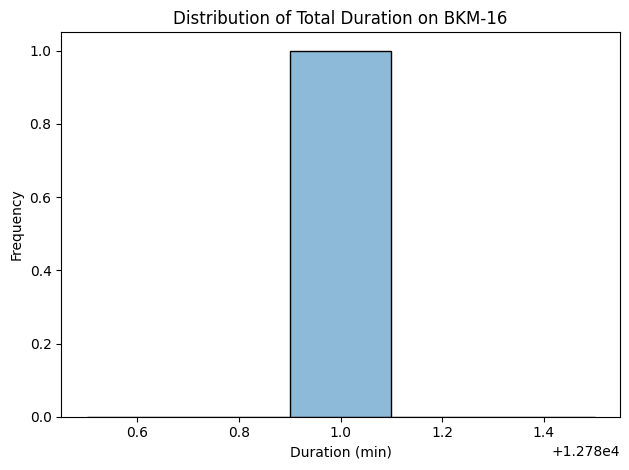

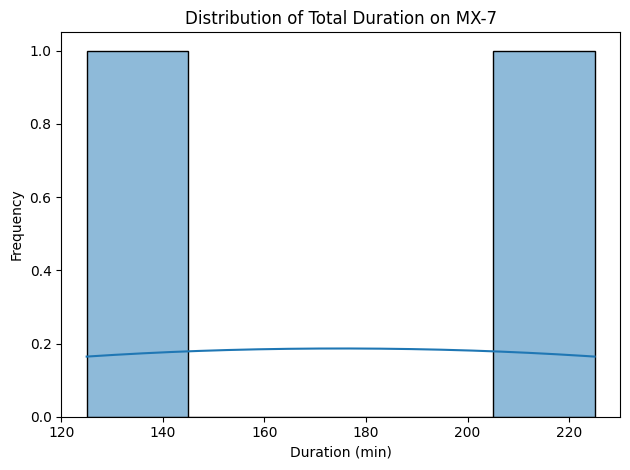

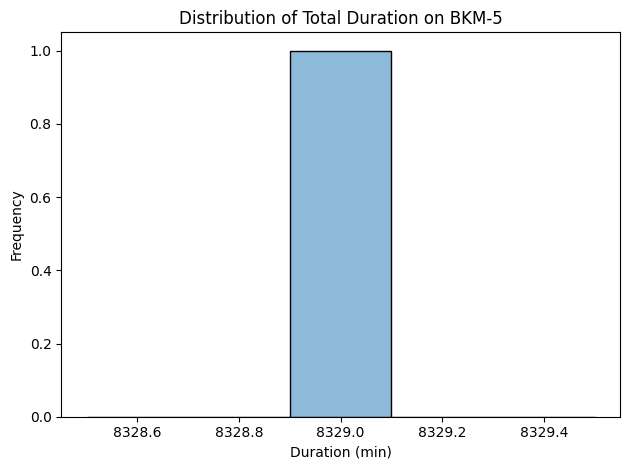

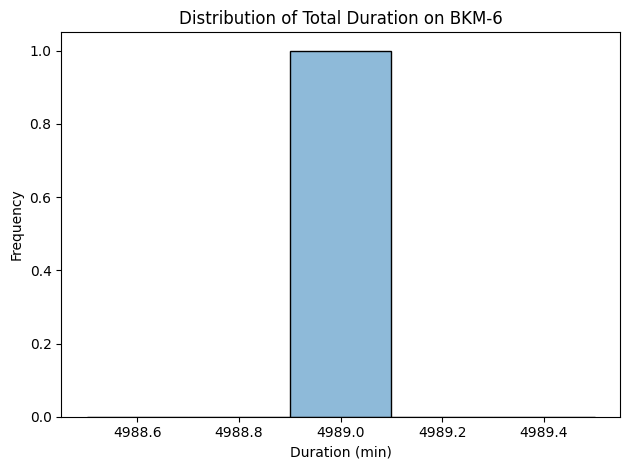

In [177]:
summary = (
    filtered_data
    .groupby(['product_code', 'machine'])['duration_min']
    .sum()
    .reset_index()
)

for machine in summary['machine'].unique():
    subset = summary[summary['machine'] == machine]['duration_min']
    plt.figure()
    sns.histplot(subset, kde=True, bins=5)
    plt.title(f'Distribution of Total Duration on {machine}')
    plt.xlabel('Duration (min)')
    plt.ylabel('Frequency')
    plt.tight_layout()
    plt.show()


In [178]:
# Determiniing the most common product code per machine
summary.groupby('machine')['product_code'].nunique().sort_values(ascending=False)


machine
HSM-1     3
MX-4      3
PMX-2     3
MX-3      2
MX-5      2
MX-6      2
MX-7      2
PMX-4     2
BKM-11    1
BKM-16    1
BKM-5     1
BKM-6     1
Name: product_code, dtype: int64

# Simplifying the Machine Numbers
Let's look at the distribution for the machines as a whole

In [179]:
filtered_data['machine_group'] = filtered_data['machine'].str.split('-').str[0]

# Aggregate duration per product per machine group
summary_grouped = (
    filtered_data
    .groupby(['product_code', 'machine_group'])['duration_min']
    .sum()
    .reset_index()
)

# List of distributions to test (taught in classes)
distributions = ['norm', 'lognorm', 'gamma', 'triang', 'expon']

# Fit distributions per machine group
results = []

for group in summary_grouped['machine_group'].unique():
    data = summary_grouped[summary_grouped['machine_group'] == group]['duration_min'].dropna()
    
    if len(data) < 3:
        results.append({
            'machine_group': group,
            'best_fit': 'Insufficient data',
            'p_value': None,
            'params': None
        })
        continue

    best_fit = None
    best_p = 0
    best_params = None

    for dist_name in distributions:
        dist = getattr(stats, dist_name)
        try:
            params = dist.fit(data)
            stat, p = stats.kstest(data, dist_name, args=params)
            if p > best_p:
                best_fit = dist_name
                best_p = p
                best_params = params
        except Exception as e:
            continue

    results.append({
        'machine_group': group,
        'best_fit': best_fit,
        'p_value': round(best_p, 4),
        'params': tuple(round(p, 4) for p in best_params) if best_params else None
    })

# Convert to DataFrame
dist_results_grouped = pd.DataFrame(results)
dist_results_grouped


,machine_group,best_fit,p_value,params
0,BKM,norm,0.8725,"(13609.0, 821.0615)"
1,HSM,norm,0.5205,"(231.6667, 30.6413)"
2,MX,norm,0.9518,"(3687.3333, 2355.8419)"
3,PMX,norm,0.9826,"(3936.3333, 2700.4425)"


# Looking at Production Batches
We realised that we should be looking at production batches instead of product number, as such we approach with a different strategy by batch grouping

In [180]:
summary_grouped = (
    filtered_data
    .groupby(['batch_no', 'machine_group'])['duration_min']
    .sum()
    .reset_index()
)
summary_grouped

,batch_no,machine_group,duration_min
0,-gjFgpJ1d34fQhrswhECYf,BKM,600.0
1,-zEn2HtTmC4_aBm8EbD9ne,BKM,1140.0
2,-zEn2HtTmC4_aBm8EbD9ne,HSM,15.0
3,-zEn2HtTmC4_aBm8EbD9ne,MX,170.0
4,-zEn2HtTmC4_aBm8EbD9ne,PMX,165.0
...,...,...,...
227,xzyDUhNvIg436go-VJTtvd,MX,115.0
228,xzyDUhNvIg436go-VJTtvd,PMX,185.0
229,zf27NXBlBl4AISujveLxH1,BKM,510.0
230,zf27NXBlBl4AISujveLxH1,MX,159.0


In [181]:
# Filter for specific machine groups (BKM)
bkm = summary_grouped[summary_grouped['machine_group'] == 'BKM'] 
bkm.head()

,batch_no,machine_group,duration_min
0,-gjFgpJ1d34fQhrswhECYf,BKM,600.0
1,-zEn2HtTmC4_aBm8EbD9ne,BKM,1140.0
5,0UHVM07G5g49uHwPUjIX49,BKM,240.0
9,26xwngMX1C4gmj8IPo79x6,BKM,360.0
12,2KcxbQzDu-4xaTep18hv60,BKM,362.0


## Plotting distribution of each machine

In [182]:
distributions = ['norm', 'lognorm', 'gamma', 'triang', 'expon']
results = []

for group in summary_grouped['machine_group'].unique():
    data = summary_grouped[summary_grouped['machine_group'] == group]['duration_min'].dropna()
    
    if len(data) < 3:
        results.append({
            'machine_group': group,
            'best_fit': 'Insufficient data',
            'p_value': None,
            'params': None
        })
        continue

    best_fit = None
    best_p = 0
    best_params = None

    for dist_name in distributions:
        dist = getattr(stats, dist_name)
        try:
            params = dist.fit(data)
            stat, p = stats.kstest(data, dist_name, args=params)
            if p > best_p:
                best_fit = dist_name
                best_p = p
                best_params = params
        except Exception as e:
            continue

    results.append({
        'machine_group': group,
        'best_fit': best_fit,
        'p_value': round(best_p, 4),
        'params': tuple(round(p, 4) for p in best_params) if best_params else None
    })

dist_results_grouped = pd.DataFrame(results)
dist_results_grouped


,machine_group,best_fit,p_value,params
0,BKM,lognorm,0.2632,"(0.6556, 74.5418, 358.2399)"
1,HSM,lognorm,0.0000,"(7.4739, 15.0, 0.0)"
2,MX,lognorm,0.2189,"(0.5098, -6.9607, 192.3242)"
3,PMX,lognorm,0.8465,"(0.8203, 113.6264, 63.4859)"


# Finding the Minimum Times
Realised that duration times contain waiting times and may not be representative of the machine's actual processing time

In [162]:
min_durations = (
    summary_grouped
    .groupby('machine_group')['duration_min']
    .min()
    .reset_index()
    .rename(columns={'duration_min': 'min_duration'})
)

min_durations

,machine_group,min_duration
0,BKM,120.0
1,HSM,15.0
2,MX-,30.0
3,PMX,123.0


In [164]:
min_durations_by_machine = (
    filtered_data
    .groupby('machine')['duration_min']
    .min()
    .reset_index()
    .rename(columns={'duration_min': 'min_duration'})
)

min_durations_by_machine

,machine,min_duration
0,BKM-11,1.0
1,BKM-16,0.0
2,BKM-5,1.0
3,BKM-6,1.0
4,HSM-1,15.0
5,MX-3,2.0
6,MX-4,1.0
7,MX-5,1.0
8,MX-6,1.0
9,MX-7,30.0


## Let's now observe the statistics of each machine
This will allow us to find potential distributions and corresponding parameters to use in JaamSim

In [167]:
stats_by_machine = (
    filtered_data
    .groupby('machine')['duration_min']
    .agg(['min', 'max', 'mean', 'std', 'count'])
    .reset_index()
)

stats_by_machine

,machine,min,max,mean,std,count
0,BKM-11,1.0,780.0,150.285714,158.681033,98
1,BKM-16,0.0,450.0,142.011111,120.869462,90
2,BKM-5,1.0,480.0,157.150943,128.337505,53
3,BKM-6,1.0,420.0,155.906250,126.760470,32
4,HSM-1,15.0,25.0,15.444444,2.084091,45
5,MX-3,2.0,824.0,92.344828,152.145202,29
6,MX-4,1.0,189.0,45.989362,30.466091,94
7,MX-5,1.0,300.0,54.080000,53.387624,50
8,MX-6,1.0,80.0,47.952381,19.428011,21
9,MX-7,30.0,160.0,58.333333,50.265959,6


In [183]:
# Aggregate duration per batch + machine (NOT machine group)
summary_by_machine = (
    filtered_data
    .groupby(['batch_no', 'machine'])['duration_min']
    .sum()
    .reset_index()
)

# Define candidate distributions
distributions = ['norm', 'lognorm', 'gamma', 'triang', 'expon']
results = []

# Fit each distribution for each machine
for machine in summary_by_machine['machine'].unique():
    data = summary_by_machine[summary_by_machine['machine'] == machine]['duration_min'].dropna()

    if len(data) < 3:
        results.append({
            'machine': machine,
            'best_fit': 'Insufficient data',
            'p_value': None,
            'params': None
        })
        continue

    best_fit = None
    best_p = 0
    best_params = None

    for dist_name in distributions:
        dist = getattr(stats, dist_name)
        try:
            params = dist.fit(data)
            stat, p = stats.kstest(data, dist_name, args=params)
            if p > best_p:
                best_fit = dist_name
                best_p = p
                best_params = params
        except Exception as e:
            continue

    results.append({
        'machine': machine,
        'best_fit': best_fit,
        'p_value': round(best_p, 4),
        'params': tuple(round(p, 4) for p in best_params) if best_params else None
    })


dist_results_by_machine = pd.DataFrame(results)
dist_results_by_machine


,machine,best_fit,p_value,params
0,BKM-6,norm,0.7082,"(453.5455, 110.3147)"
1,BKM-5,expon,0.7503,"(240.0, 315.2667)"
2,HSM-1,lognorm,0.0000,"(7.4739, 15.0, 0.0)"
3,MX-4,gamma,0.7878,"(31.7373, -179.7273, 11.1114)"
4,PMX-2,lognorm,0.9624,"(0.5276, 86.8381, 81.0141)"
5,BKM-11,lognorm,0.6076,"(0.8415, 139.3318, 303.4454)"
6,MX-3,gamma,0.9005,"(0.7057, 185.0, 263.7812)"
7,PMX-4,lognorm,0.1684,"(0.3444, -74.6689, 263.3756)"
8,BKM-16,lognorm,0.6964,"(0.6741, 63.7144, 320.8822)"
9,MX-5,expon,0.8039,"(101.0, 124.3333)"
